In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    classification_report,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    VotingClassifier,
)

from sklearn.tree import DecisionTreeClassifier

from pprint import pprint
from joblib import dump, load

import librosa
from librosa import display, feature, stft, amplitude_to_db

In [2]:
seed = 43
results = {}

np.random.seed(seed)
df = pd.read_csv(f"dataset/gtzan/features_3_sec.csv")
classes = df["label"].unique()

# Plot Chroma STFT & Spectorgram

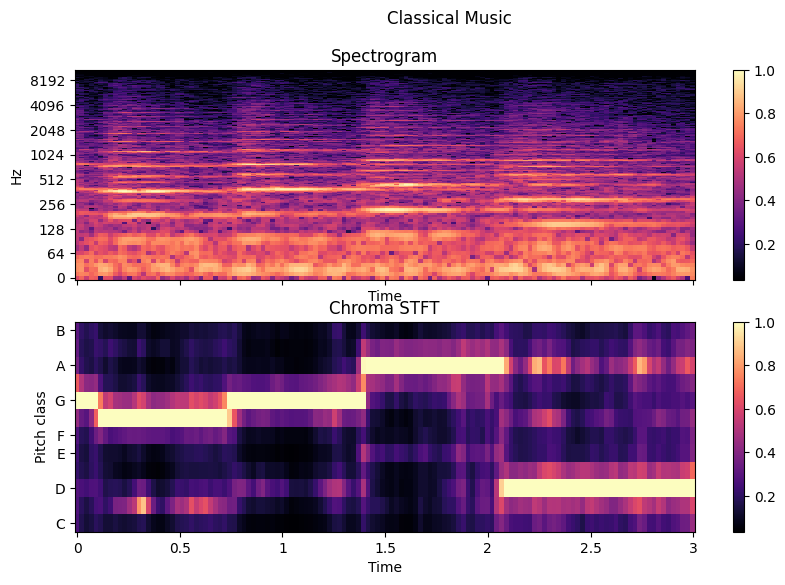

In [3]:
y, sr = librosa.load(
    "./dataset/gtzan/genres_original/classical/classical.00016.wav", duration=3
)
S = np.abs(stft(y))
chroma = feature.chroma_stft(S=S, sr=sr)

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 6))
img = display.specshow(
    amplitude_to_db(S, ref=np.max), y_axis="log", x_axis="time", ax=ax1
)

fig.suptitle("Classical Music")
ax1.set_title("Spectrogram")
ax2.set_title("Chroma STFT")

img = display.specshow(chroma, y_axis="chroma", x_axis="time", ax=ax2)

fig.colorbar(img, ax=ax1)

fig.colorbar(img, ax=ax2)

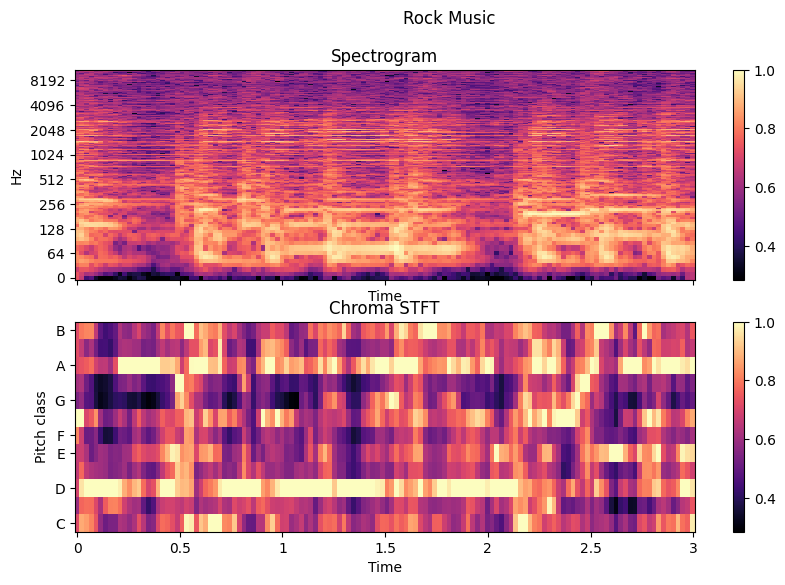

In [4]:
y, sr = librosa.load("./dataset/gtzan/genres_original/rock/rock.00039.wav", duration=3)
S = np.abs(stft(y))
chroma = feature.chroma_stft(S=S, sr=sr)

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 6))
img = display.specshow(
    amplitude_to_db(S, ref=np.max), y_axis="log", x_axis="time", ax=ax1
)

fig.suptitle("Rock Music")
ax1.set_title("Spectrogram")
ax2.set_title("Chroma STFT")


img = display.specshow(chroma, y_axis="chroma", x_axis="time", ax=ax2)

fig.colorbar(img, ax=ax1)

fig.colorbar(img, ax=ax2)

# 0. Ulitity Functions

In [9]:
def tune_model(
    model, X_train, y_train, param_grid, cv=3, verbose=2, n_jobs=-1, scoring="accuracy"
):
    """
    Tune model using grid search
    """
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        verbose=verbose,
        n_jobs=n_jobs,
        scoring=scoring,
    )
    gs.fit(X_train, y_train)

    return gs, gs.best_estimator_

In [10]:
def evaluate_model(
    model,
    X_test,
    y_test,
):
    """
    Compute model train & test accuracy scores
    """
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, digits=3))

    train_accuracy = accuracy_score(y_train, y_train)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Train accuracy: {train_accuracy}")
    print(f"Test accuracy: {test_accuracy}")

    return test_accuracy

In [11]:
def plot_confusion_matrix(model, X_test, y_test, label="Hello"):
    """
    Plot confusion matrix and accuracy of the model for each genre
    """
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=range(len(classes)))

    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    fig, ax = plt.subplots(
        1, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [2, 2.5]}
    )

    fig.suptitle(label)

    ax[0].set_title("Confustion Matrix")
    display.plot(cmap="Blues", colorbar=False, ax=ax[0], xticks_rotation=90)

    report = classification_report(
        y_test, y_pred, target_names=classes, zero_division=True, output_dict=True
    )

    class_names = list(report.keys())[:-3]
    accuracy_per_class = [report[class_name]["precision"] for class_name in class_names]

    ax[1].bar(class_names, accuracy_per_class)
    ax[1].tick_params(rotation=90)
    ax[1].set_xlabel("Class")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_title("Accuracy Per Class")
    ax[1].set_ylim(0, 1)

# 1. Dataset Analysis and Preprocessing

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   chroma_stft_mean         9990 non-null   float64
 1   chroma_stft_var          9990 non-null   float64
 2   rms_mean                 9990 non-null   float64
 3   rms_var                  9990 non-null   float64
 4   spectral_centroid_mean   9990 non-null   float64
 5   spectral_centroid_var    9990 non-null   float64
 6   spectral_bandwidth_mean  9990 non-null   float64
 7   spectral_bandwidth_var   9990 non-null   float64
 8   rolloff_mean             9990 non-null   float64
 9   rolloff_var              9990 non-null   float64
 10  zero_crossing_rate_mean  9990 non-null   float64
 11  zero_crossing_rate_var   9990 non-null   float64
 12  harmony_mean             9990 non-null   float64
 13  harmony_var              9990 non-null   float64
 14  perceptr_mean           

In [33]:
df

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,8.479527e+05,...,5.773784,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969
9986,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,1.170890e+06,...,2.074155,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033
9987,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,2.602871e+06,...,-1.005473,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990
9988,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,4.968878e+05,...,4.123402,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750


In [27]:
le = LabelEncoder()
encoded_labels = le.fit_transform(df["label"])

df = df.drop(["label", "filename", "length"], axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df, encoded_labels, train_size=0.7)

In [29]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# 2. Standalone Approaches

## 2.1. Random Forest


In [ ]:
rfc = RandomForestClassifier(
    max_depth=64, n_estimators=500, criterion="gini", n_jobs=-1
)
rfc.fit(X_train, y_train)

evaluate_model(rfc, X_test, y_test)
plot_confusion_matrix(rfc, X_test, y_test, label="Random Forest")

In [ ]:
random_forest_param_grid = {
    "n_estimators": [10, 20, 50, 100, 200, 300, 500, 800, 1000],
    "max_depth": np.linspace(1, 60, num=5, dtype=int).tolist(),
}

pprint(random_forest_param_grid)

In [ ]:
rf_estimator = RandomForestClassifier(n_jobs=-1)

gs, rf_tuned = tune_model(
    rf_estimator, X_train, y_train, param_grid=random_forest_param_grid
)

In [ ]:
gs.best_params_

In [ ]:
evaluate_model(rf_tuned, X_test, y_test)
plot_confusion_matrix(rf_tuned, X_test, y_test, label="Tuned Random Forest")

In [ ]:
dump(rf_tuned, filename="./rf_tuned.joblib")

## 2.2. AdaBoost


In [ ]:
abc = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=500,
    learning_rate=0.1,
    algorithm="SAMME",
)
abc.fit(X_train, y_train)

evaluate_model(abc, X_test, y_test, cross_val=False)

plot_confusion_matrix(abc, X_test, y_test, label="AdaBoost")

In [ ]:
adaboost_estimator = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3))

adaboost_param_grid = {
    "n_estimators": np.linspace(500, 2000, 4, dtype=np.int32).tolist(),
    "learning_rate": [0.1, 0.08, 0.01],
    "algorithm": ["SAMME"],
}

gs, adaboost_tuned = tune_model(
    adaboost_estimator, X_train, y_train, param_grid=adaboost_param_grid, cv=5
)

In [ ]:
evaluate_model(adaboost_tuned, X_test, y_test)
plot_confusion_matrix(adaboost_tuned, X_test, y_test, label="Tuned AdaBoost")

In [ ]:
dump(adaboost_tuned, "adaboost_tuned.joblib")

## 2.3. XGBoosting


In [ ]:
import xgboost as xgb
from scipy.stats import uniform, randint

xgbc = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.2,
    max_depth=6,
)
xgbc.fit(X_train, y_train)

evaluate_model(xgbc, X_test, y_test)
plot_confusion_matrix(xgbc, X_test, y_test, label="XGBoost")

In [ ]:
xgb_estimator = xgb.XGBClassifier()

xgb_param_grid = {
    "learning_rate": np.linspace(0.03, 0.3, 5).tolist(),
    "max_depth": np.linspace(2, 6, 5, dtype=int).tolist(),  # default 3
    "n_estimators": [100, 150, 200, 250, 300],  # default 100
}

gs, xgb_tuned = tune_model(xgb_estimator, X_train, y_train, param_grid=xgb_param_grid)


xgb_tuned.fit(X_train, y_train)

In [ ]:
pprint(xgb_param_grid)

In [ ]:
evaluate_model(xgb_tuned, X_test, y_test)
plot_confusion_matrix(xgb_tuned, X_test, y_test, "Tuned XGBoost")

In [ ]:
dump(xgb_tuned, filename="xgboost_tuned.joblib")

## 2.4 Feedforward Neural Network

In [ ]:
from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

model = Sequential(
    [
        Input((X_train.shape[1],)),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(10, activation="softmax"),
    ]
)

EPOCHS = 50
BATCH_SIZE = 32

fnn = KerasClassifier(
    model=model,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
fnn.fit(X_train, y_train)

In [ ]:
model.summary()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle("Feedforwarn Neural Network")

ax1.plot(model.history.history["loss"], label="Training Loss")
ax1.plot(model.history.history["val_loss"], label="Validation Loss")
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(model.history.history["accuracy"], label="Accuracy Loss")
ax2.plot(model.history.history["val_accuracy"], label="Accuracy Loss")
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

In [ ]:
evaluate_model(fnn, X_test, y_test)

In [ ]:
plot_confusion_matrix(fnn, X_test, y_test, "Feedforward Neural Network")

In [ ]:
dump(fnn, filename="./fnn.joblib")

# 3. Voting Classifier

In [12]:
results = {}

# Comment if not using dumped models
rf_clf = load("rf_tuned.joblib")
adaboost_clf = load("adaboost_tuned.joblib")
xgboost_clf = load("xgboost_tuned.joblib")
fnn_clf = load("fnn.joblib")


results["Random Forest"] = evaluate_model(rf_clf, X_test, y_test)
results["AdaBoost"] = evaluate_model(adaboost_clf, X_test, y_test)
results["XGBoosting"] = evaluate_model(xgboost_clf, X_test, y_test)
results["FNN"] = evaluate_model(fnn_clf, X_test, y_test)

              precision    recall  f1-score   support

           0      0.872     0.890     0.881       292
           1      0.934     0.972     0.953       322
           2      0.810     0.878     0.843       296
           3      0.850     0.864     0.857       295
           4      0.918     0.852     0.884       304
           5      0.897     0.911     0.904       316
           6      0.885     0.922     0.903       283
           7      0.899     0.854     0.876       302
           8      0.844     0.865     0.855       275
           9      0.888     0.785     0.833       312

    accuracy                          0.880      2997
   macro avg      0.880     0.880     0.879      2997
weighted avg      0.881     0.880     0.880      2997

Train accuracy: 1.0
Test accuracy: 0.8798798798798799
              precision    recall  f1-score   support

           0      0.648     0.705     0.675       292
           1      0.934     0.786     0.853       322
           2      0.617 

I0000 00:00:1715886166.537851   13412 service.cc:145] XLA service 0x7fa1a0005830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715886166.537890   13412 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-05-16 22:02:46.542676: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-16 22:02:46.575485: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


51/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

I0000 00:00:1715886168.272505   13412 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
              precision    recall  f1-score   support

           0      0.932     0.894     0.913       292
           1      0.941     0.941     0.941       322
           2      0.823     0.895     0.858       296
           3      0.872     0.851     0.861       295
           4      0.906     0.914     0.910       304
           5      0.900     0.937     0.918       316
           6      0.955     0.905     0.929       283
           7      0.884     0.881     0.882       302
           8      0.844     0.884     0.863       275
           9      0.901     0.843     0.871       312

    accuracy                          0.895      2997
   macro avg      0.896     0.894     0.895      2997
weighted avg      0.896     0.895     0.895      2997

Train accuracy: 1.0
Test accuracy: 0.8948948948948949


In [ ]:
vc = VotingClassifier(
    [
        ("XGBoosting", xgboost_clf),
        ("RandomForest", rf_clf),
        # ("AdaBoost", adaboost_clf),
        ("FNN", fnn_clf),
    ],
    voting="soft",
)

In [ ]:
vc.fit(X_train, y_train)

In [ ]:
# dump(vc, filename="xg_rf_fnn_best.joblib")
# dump(vc, "vc_full.joblib")
# dump(vc, "vc_no_ada.joblib")

In [ ]:
results["Voting Classifier"] = evaluate_model(vc, X_test, y_test)

plot_confusion_matrix(vc, X_test, y_test, label="Voting Classifier")

# 4. Best Classifier Analysis

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0      0.921     0.962     0.941       292
           1      0.946     0.981     0.963       322
           2      0.907     0.926     0.916       296
           3      0.923     0.895     0.909       295
           4      0.953     0.931     0.942       304
           5      0.931     0.934     0.932       316
           6      0.940     0.933     0.936       283
           7      0.919     0.901     0.910       302
           8      0.905     0.902     0.903       275
           9      0.911     0.891     0.901       312

    accuracy                          0.926      2997
   macro avg      0.926     0.926     0.925      2997
weighted avg      0.926     0.926     0.926      2997

Train accuracy: 1.0
Test accuracy: 0.9259259259259259
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


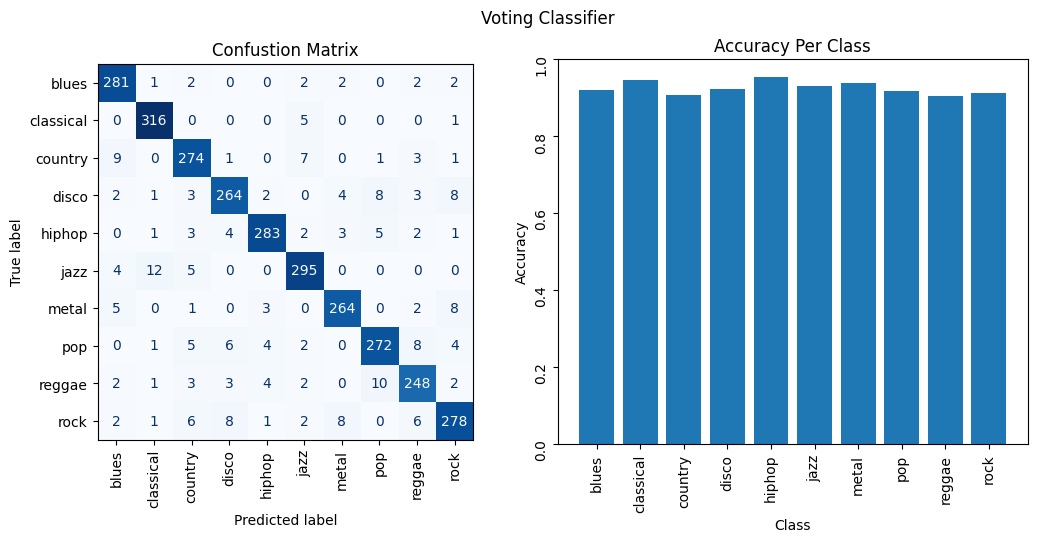

In [14]:
voting_clf = load("xg_rf_fnn_best.joblib")
results["Voting Classifier"] = evaluate_model(voting_clf, X_test, y_test)

plot_confusion_matrix(voting_clf, X_test, y_test, label="Voting Classifier")

# 5. Results

In [15]:
from sklearn.metrics import precision_score

precision = {}

precision["Voting Classifier"] = precision_score(
    y_test, voting_clf.predict(X_test), average="weighted"
)
precision["XGBoost"] = precision_score(
    y_test, xgboost_clf.predict(X_test), average="weighted"
)
precision["Random Forest"] = precision_score(
    y_test, rf_clf.predict(X_test), average="weighted"
)
precision["FNN"] = precision_score(y_test, fnn_clf.predict(X_test), average="weighted")
precision["AdaBoost"] = precision_score(
    y_test, adaboost_clf.predict(X_test), average="weighted"
)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


In [16]:
pprint(precision)

{'AdaBoost': 0.6928752401631432,
 'FNN': 0.8961405605477023,
 'Random Forest': 0.8807992642665057,
 'Voting Classifier': 0.9259095861981994,
 'XGBoost': 0.904672081007642}


In [17]:
pprint(results)

{'AdaBoost': 0.6880213546880214,
 'FNN': 0.8948948948948949,
 'Random Forest': 0.8798798798798799,
 'Voting Classifier': 0.9259259259259259,
 'XGBoosting': 0.9045712379045713}


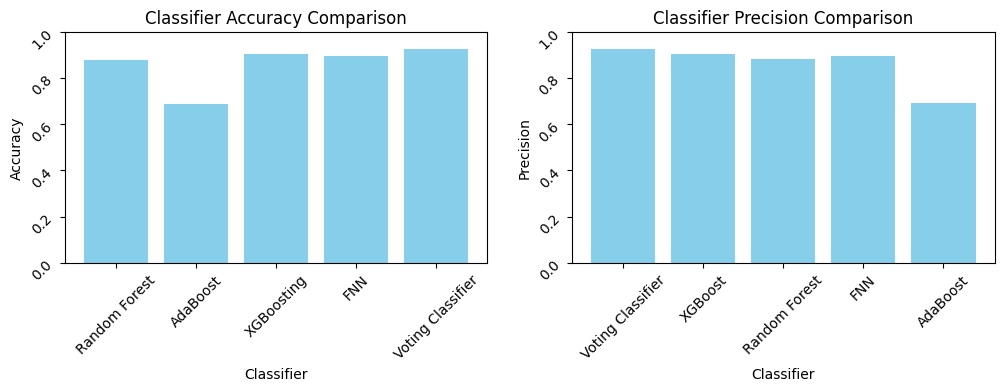

In [18]:
classifiers1 = list(precision.keys())
precisions = list(precision.values())

classifiers2 = list(results.keys())
accuracies = list(results.values())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))


ax1.bar(classifiers2, accuracies, color="skyblue")
ax1.set_xlabel("Classifier")
ax1.set_ylabel("Accuracy")
ax1.set_title("Classifier Accuracy Comparison")
ax1.set_ylim(0, 1)
ax1.tick_params(rotation=45)

ax2.bar(classifiers1, precisions, color="skyblue")
ax2.set_xlabel("Classifier")
ax2.set_ylabel("Precision")
ax2.set_title("Classifier Precision Comparison")
ax2.set_ylim(0, 1)
ax2.tick_params(rotation=45)